In [2]:
import pandahouse as ph
import pandas as pd
import numpy as np
import hashlib
from scipy import stats
from scipy.stats import ttest_ind
import pylab

### Проверяем работает ли система сплитования корректно, и ключевая метрика не отличается между группами не только в конкретно нашем АА-тесте, но и в целом.

In [5]:
#Подключаемся к базе данных
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230420',
                      'user':'student', 
                      'password':'dpo_python_2020'} 

In [4]:
#Прописываем необходимый sql запрос на даты проведения нашего АА теста
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-03-25' and '2023-03-31'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

df.groupby('exp_group').count() #смотрим на группы

,user_id,likes,views,ctr
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


In [7]:
exp_group_A = df.query("exp_group == 2") #Выбираем из БД группу А с группой 2
exp_group_B = df.query("exp_group == 3") #Выбираем из БД группу B с группой 3

In [6]:
exp_group_A

,exp_group,user_id,likes,views,ctr
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667
5,2,24239,53,119,0.445378
7,2,14680,8,70,0.114286
...,...,...,...,...,...
17042,2,25071,38,159,0.238994
17043,2,17146,8,75,0.106667
17045,2,25383,16,57,0.280702
17047,2,108927,8,33,0.242424


In [7]:
exp_group_B

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
6,3,19647,21,146,0.143836
10,3,107670,25,115,0.217391
11,3,126702,3,12,0.250000
...,...,...,...,...,...
17036,3,122758,37,212,0.174528
17039,3,130651,7,25,0.280000
17040,3,13489,6,42,0.142857
17044,3,122008,4,31,0.129032


In [8]:
result = []
for _ in range(10000): #делаем 10000 итераций

    a = pd.Series(exp_group_A['ctr']).sample(500, replace = False) #сэмплируем без возвращения 500 юзеров
    b = pd.Series(exp_group_B['ctr']).sample(500, replace = False) 
    _, pval = ttest_ind(a, b, equal_var = False) #проверяем ТТестом
    result.append(pval)

In [9]:
ttest_res = pd.Series(result) #сохраняем наш результат в серию

<AxesSubplot:>

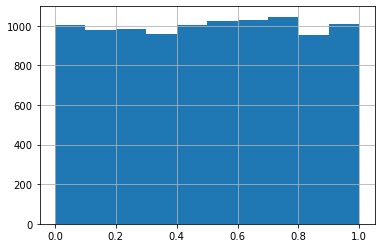

In [10]:
ttest_res.hist() #Построим гистограмму распределения получившихся 10000 p-values и проверяем его на равномерное распределение

In [11]:
(ttest_res < 0.05).mean() #считаем какой процент  p values оказался меньше либо равен 0.05

0.0467

Также распределение можно проверить на равномерность с помощью QQ графика.

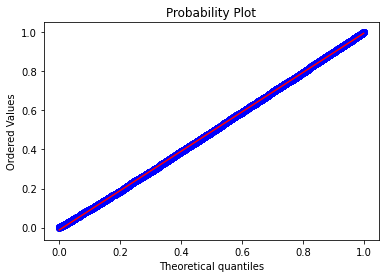

In [14]:
stats.probplot(ttest_res, dist = "uniform", plot = pylab)
pylab.show()

ВЫВОД: По построенным  графикам видно, что наше распределение равномерное. Проверили ошибку 1 рода, получили результат ~5%, что говорит нам о том, что наша альфа действительно является ошибкой 1 рода(H1), т.е. мы всегда будем получать 5% ошибок при верной 0 гипотизе(H0). Делаем вывод наша система сплитования работает корректно и ключевая метрика не отличается между группами (разницы нет).